In [2]:
# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

libdecor-gtk-WARNING: Failed to initialize GTK
Failed to load plugin 'libdecor-gtk.so': failed to init
No plugins found, falling back on no decorations


""

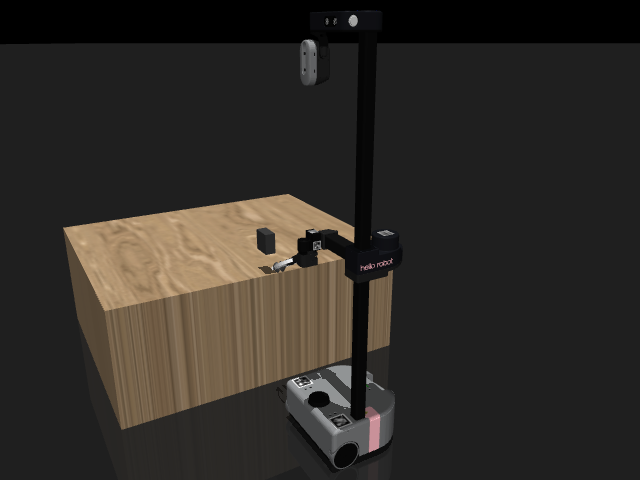

In [3]:
from pathlib import Path
import enum
from tqdm import tqdm

class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)

res = Resolution.SD
h, w = res.value

model_dir = Path("mujoco_menagerie/hello_robot_stretch") # You could also use google_robot
model_xml = model_dir / "scene.xml"

# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [4]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [5]:
vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 6

duration = 10
fps = 30
nsteps = int(np.ceil(duration / model.opt.timestep))

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)


In [6]:
# print(data.joint(3))
# model.opt.timestep
nsteps

5000

In [7]:
'''
import mujoco
import numpy as np

# Определим параметры робота
wheel_base = 0.5  # расстояние между колесами в метрах

# Начальные условия
x, y, theta = 0.0, 0.0, 0.0  # начальные координаты и угол (в радианах)

# Целевая точка
target_x, target_y = 2.0, 2.0  # координаты цели

# Точность достижения цели
tolerance = 0.1  # 10 см

# Шаг симуляции (время шага)
dt = 0.01  # 10 мс

# Параметры контроллера
k_linear = 1.0  # коэффициент пропорциональности для линейной скорости
k_angular = 2.0  # коэффициент пропорциональности для угловой скорости

# Определим функцию для обновления одометрии
def update_odometry(data, x, y, theta, dt):
    linear_velocity = data.ctrl[0]  # линейная скорость
    angular_velocity = data.ctrl[1]  # угловая скорость (радиус поворота)

    # Вычисление изменения позиций
    delta_theta = angular_velocity * dt
    delta_x = linear_velocity * dt * np.cos(theta + delta_theta / 2)
    delta_y = linear_velocity * dt * np.sin(theta + delta_theta / 2)

    # Обновление позиции и угла
    x += delta_x
    y += delta_y
    theta += delta_theta

    # Нормализация угла
    theta = (theta + np.pi) % (2 * np.pi) - np.pi

    return x, y, theta

# Функция для расчета скоростей
def calculate_speeds(x, y, theta, target_x, target_y):
    # Вычисляем угловую ошибку
    angle_to_target = np.arctan2(target_y - y, target_x - x)
    angle_error = angle_to_target - theta

    # Нормализация угловой ошибки
    angle_error = (angle_error + np.pi) % (2 * np.pi) - np.pi

    # Пропорциональное управление угловой скоростью
    angular_velocity = k_angular * angle_error

    # Пропорциональное управление линейной скоростью
    distance_to_target = np.sqrt((target_x - x)**2 + (target_y - y)**2)
    linear_velocity = k_linear * distance_to_target

    # Ограничение скоростей
    max_linear_velocity = 0.2  # м/с
    max_angular_velocity = 1.0  # рад/с

    linear_velocity = np.clip(linear_velocity, 0, max_linear_velocity)
    angular_velocity = np.clip(angular_velocity, -max_angular_velocity, max_angular_velocity)

    return linear_velocity, angular_velocity

# Установим начальные управляющие воздействия
data.ctrl[0] = 1 # линейная скорость 0.1 м/с
data.ctrl[1] = 0.05  # угловая скорость 0.05 рад/с

# Количество шагов симуляции
frames = []

for i in tqdm(range(nsteps)):
    # Расчет управляющих воздействий
    linear_velocity, angular_velocity = calculate_speeds(x, y, theta, target_x, target_y)

    data.ctrl[0] = linear_velocity
    data.ctrl[1] = angular_velocity

    # Обновление состояния робота
    x, y, theta = update_odometry(data, x, y, theta, dt)

    # Проверка достижения цели
    distance_to_target = np.sqrt((target_x - x)**2 + (target_y - y)**2)
    if distance_to_target <= tolerance:
        # Остановка робота
        data.ctrl[0] = 0.0
        data.ctrl[1] = 0.0
        # print(f"Target reached at step {step}: x: {x:.3f}, y: {y:.3f}, theta: {theta:.3f}")
        break
    
    mujoco.mj_step(model, data)
    if len(frames) < data.time * fps:
        renderer.update_scene(data, camera, scene_option=vis)
        vispix = renderer.render().copy().astype(np.float32)
        frame = vispix.astype(np.uint8)
        frames.append(frame)
            
media.show_video(frames, fps=fps, loop=False)
'''


'\nimport mujoco\nimport numpy as np\n\n# Определим параметры робота\nwheel_base = 0.5  # расстояние между колесами в метрах\n\n# Начальные условия\nx, y, theta = 0.0, 0.0, 0.0  # начальные координаты и угол (в радианах)\n\n# Целевая точка\ntarget_x, target_y = 2.0, 2.0  # координаты цели\n\n# Точность достижения цели\ntolerance = 0.1  # 10 см\n\n# Шаг симуляции (время шага)\ndt = 0.01  # 10 мс\n\n# Параметры контроллера\nk_linear = 1.0  # коэффициент пропорциональности для линейной скорости\nk_angular = 2.0  # коэффициент пропорциональности для угловой скорости\n\n# Определим функцию для обновления одометрии\ndef update_odometry(data, x, y, theta, dt):\n    linear_velocity = data.ctrl[0]  # линейная скорость\n    angular_velocity = data.ctrl[1]  # угловая скорость (радиус поворота)\n\n    # Вычисление изменения позиций\n    delta_theta = angular_velocity * dt\n    delta_x = linear_velocity * dt * np.cos(theta + delta_theta / 2)\n    delta_y = linear_velocity * dt * np.sin(theta + delt

In [8]:
duration = 10
fps = 30
nsteps = int(np.ceil(duration / model.opt.timestep))
nsteps
model.opt.timestep

0.002

In [52]:
from math import *

class Robot:
    def __init__(self, model, data, vis, coll, camera):
        self.model = model
        self.data = data
        self.vis = vis
        self.coll = coll
        self.camera = camera
        self.x = 0
        self.y = 0
        self.tangent_angle = 0.0
        self.velocity = 0.0
        self.breadth = 0.0
        self.dt = model.opt.timestep
        self.treshold = 1
        self.positioins = list()

    def set_wheel_speeds(self, left_speed, right_speed):
        self.data.joint('joint_left_wheel').qvel = np.array([left_speed])
        self.data.joint('joint_right_wheel').qvel = np.array([right_speed])        
        # print(left_speed, right_speed)
        # data.ctrl[0] = -1 * (left_speed + right_speed) / 2.0

    def distance_to_point(self, x_goal, y_goal, x, y):
        return sqrt((x_goal - x) ** 2 + (y_goal - y) ** 2)
    
    def arc_radius(x1, y1, x2, y2, tangent_angle):
        chord_length = sqrt((x2 - x1)**2 + (y2 - y1)**2)
        chord_angle = atan2(y2 - y1, x2 - x1)
        arc_angle = 2 * chord_angle
        if arc_angle > 2 * pi:
            arc_angle -= 2 * pi
        elif arc_angle < 2 * pi:
            arc_angle += 2 * pi
        next_tangent_angle = tangent_angle + arc_angle
        radius = (chord_length / 2) * sin(arc_angle/2)
        return radius, next_tangent_angle, chord_length, chord_angle

    def step(self, x_goal, y_goal):
        radius, next_tangent_angle, chord_length, chord_angle = self.arc_radius(self.x, self.y, x_goal, y_goal, self.tangent_angle)
        # Calc position
        delta_x = chord_length * cos(self.tangent_angle + chord_angle) * self.dt
        delta_y = chord_length * sin(self.tangent_angle + chord_angle) * self.dt
        self.x += delta_x
        self.y += delta_y
        self.tangent_angle = next_tangent_angle
        # Set wheels velocities
        wheel_base = self.breadth
        v = self.velocity
        omega = v / radius
        if abs(chord_angle) < pi/2:
            left_speed = omega * (radius - wheel_base/2)
            right_speed = omega * (radius + wheel_base/2)
        else:
            left_speed = omega * (radius + wheel_base/2)
            right_speed = omega * (radius - wheel_base/2)
        if 2 * chord_angle < 0:
            left_speed = -1 * left_speed
            right_speed = -1 * right_speed        
        self.set_wheel_speeds(self, left_speed, right_speed)
        self.positioins.append(model.joint(3).pos)
    
    def control_robot_to_point(self, x_goal, y_goal):
        duration = 10
        fps = 30
        nsteps = int(np.ceil(duration / model.opt.timestep))
        frames = []

        # Set the desired control point.
        if model.nkey > 0:
            mujoco.mj_resetDataKeyframe(model, data, 0)
            ctrl0 = data.ctrl.copy()
        else:
            mujoco.mj_resetData(model, data)
            ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)
        
        # Movement steps
        for i in tqdm(range(nsteps)):
            distance = self.distance_to_point(self, x_goal, y_goal, self.x, self.y)    
            if distance > self.treshold:
                self.step(self, x_goal, y_goal)
            else:
                self.set_wheel_speeds(self, 0, 0)
                print("Reached the goal and stopped.")
            # Rendering
            mujoco.mj_step(model, data)
            if len(frames) < data.time * fps:
                renderer.update_scene(data, self.camera, scene_option=self.vis)
                vispix = renderer.render().copy().astype(np.float32)
                frame = vispix.astype(np.uint8)
                frames.append(frame)
            
        media.show_video(frames, fps=fps, loop=False)

        self.set_wheel_speeds(self, 0, 0)
        

robot = Robot
robot.__init__(robot, model, data, vis, coll, camera)
robot.velocity = 1
robot.breadth = 3.4
x_goal, y_goal = -3, -3
robot.x, robot.y = 0, 0 
robot.treshold = 1
robot.tangent_angle = 0
robot.control_robot_to_point(robot, x_goal, y_goal)
print(robot.positioins)


100%|██████████| 5000/5000 [00:02<00:00, 1734.33it/s]


[array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0

In [34]:
# print(model.joint(3).pos)


[array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0